# 2013TSA Phenotype ML Modeling

### Predict behavioral elimination using 2013 TSA phenotype scores

Alex Eyre (2022)

____
### Define Functions; Package Import

In [1]:
def remcols(table,indices):
    for idx in indices:
        table = table[table[idx] != "Not Recorded"]
    return table

In [2]:
def histplots(data, idx_list, ax_idx):
    bins_list = [1,2,3,4,5,6]
    i         = 0     
    nrow      = 0
    ncol      = 0
    
    while nrow < len(ax_idx):
        ncol = 0
        while ncol < len(ax_idx[0]):
            if i == len(data.columns):
                break
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i].dropna(),
                                    bins    = bins_list,
                                    range   = (1,6),
                                    alpha   = 0.5,
                                    color   = "blue",
                                    density = True)
            ax_idx[nrow, ncol].set_title(idx_list[i])
            ncol = ncol + 1
            i = i + 1    
        nrow = nrow + 1

In [3]:
def normplots(data, idx_list, ax_idx):
    i         = 0     
    nrow      = 0
    ncol      = 0
    
    while nrow < len(ax_idx):
        ncol = 0
        while ncol < len(ax_idx[0]):
            if i == len(data.columns):
                break
            
            bins_list = [0,1,2,3,4,5]
            max_val   = max(data.iloc[:,i].dropna())
            min_val   = min(data.iloc[:,i].dropna())
            step_size  = (max_val - min_val) / 5
            bins_list = [min_val + (x * step_size) for x in bins_list]         # "List Comprehension"
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i].dropna(),
                                    bins    = bins_list,
                                    range   = (min_val, max_val),
                                    alpha   = 0.5,
                                    color   = "blue",
                                    density = True)
            
            ax_idx[nrow, ncol].set_title(idx_list[i])
            
            ncol = ncol + 1
            i = i + 1    
        nrow = nrow + 1

In [4]:
def compareplots(data, idx_list, ax_idx):
    bins_list = [1,2,3,4,5,6]
    i         = 1     
    nrow      = 0
    ncol      = 0
    
    while nrow < len(ax_idx):
        ncol = 0
        while ncol < len(ax_idx[0]):
            if i == len(data.columns):
                break
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i][data["BehElim"] == 0],
                                    bins    = bins_list,
                                    range   = (0,6),
                                    alpha   = 0.5,
                                    color   = "blue",
                                    density = True)
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i][data["BehElim"] == 1],
                                    bins    = bins_list,
                                    range   = (0,6),
                                    alpha   = 0.5,
                                    color   = "orange",
                                    density = True)  
                
            ax_idx[nrow, ncol].set_title(idx_list[i-1])
            ncol = ncol + 1
            i = i + 1    
        nrow = nrow + 1

In [5]:
def makelabels(labels):
    i = 0
    while i < len(labels):
        if labels[i] == 0:
            labels[i] = "Accepted"
        else:
            labels[i] = "Eliminated"
        i = i + 1
    return labels

In [6]:
def bootstrap_FS(X, y, num_bs):
    bs_data = []
    bs_data.append("Run#\tNumFeatures\tFeatures\n")
    
    i = 0
    while i < num_bs:
        curr_data = []
        
        rf = RandomForestClassifier(random_state = i)
        rfecv = RFECV(
            estimator = rf,
            step = 1,
            cv = None,
            scoring = "accuracy",
            min_features_to_select = 1
        )
        
        rfecv.fit(X, list(y))
        curr_data = "%s\t%s\t%s\n" % (i+1,
                                      rfecv.n_features_,
                                      "\t".join(list(X.columns[rfecv.support_])))

        bs_data.append(curr_data)
        i = i + 1
    
    return(bs_data)

In [7]:
def unique(list1):
 
    unique_list = []
     
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
            
    return unique_list

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import pi
import time

# Radar Plots
import plotly.graph_objects as go

# Classification Tasks
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Prediction Tasks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.style.use('seaborn-darkgrid')

____
### Data Import + Cleanup

In [9]:
M03 = pd.read_excel("M03.xlsx")
M06 = pd.read_excel("M06.xlsx")
M09 = pd.read_excel("M09.xlsx")
M12 = pd.read_excel("M12.xlsx")

In [10]:
# First set of indices contain behavioral elimination, second do not
Env_Idx        = ["BehElim", "Confidence", "Concentration", "Responsiveness", "Initiative",
                  "Excitability", "Hearing Sensitivity", "Body Sensitivity", "CR", "IP", "PP"]
Test_Idx       = ["BehElim", "CR.1", "MP", "PP.1", "IP.1", "HG", "H1", "H2", "ACT"]

Env_Idx1       = ["Confidence", "Concentration", "Responsiveness", "Initiative",
                  "Excitability", "Hearing Sensitivity", "Body Sensitivity", "CR", "IP", "PP"]
Test_Idx1      = ["CR.1", "MP", "PP.1", "IP.1", "HG", "H1", "H2", "ACT"]

In [11]:
# Remove dogs from the tests if they contain missing information
M03_Env       = remcols(M03[Env_Idx].dropna(), Env_Idx1)
M03_Test      = remcols(M03[Test_Idx].dropna(), Test_Idx1)
M06_Env       = remcols(M06[Env_Idx].dropna(), Env_Idx1) 
M06_Test      = remcols(M06[Test_Idx].dropna(), Test_Idx1)
M09_Env       = remcols(M09[Env_Idx].dropna(), Env_Idx1)
M09_Test      = remcols(M09[Test_Idx].dropna(), Test_Idx1)
M12_Env       = remcols(M12[Env_Idx].dropna(), Env_Idx1)
M12_Test      = remcols(M12[Test_Idx].dropna(), Test_Idx1)

In [12]:
# Z-score Normalized Data
M03_EnvZsc    = pd.concat([M03_Env["BehElim"], (M03_Env[Env_Idx1] - M03_Env[Env_Idx1].mean()) / M03_Env[Env_Idx1].std()], axis = 1)
M03_TestZsc   = pd.concat([M03_Env["BehElim"], (M03_Test[Test_Idx1] - M03_Test[Test_Idx1].mean()) / M03_Test[Test_Idx1].std()], axis = 1)
M06_EnvZsc    = pd.concat([M03_Env["BehElim"], (M06_Env[Env_Idx1] - M06_Env[Env_Idx1].mean()) / M06_Env[Env_Idx1].std()], axis = 1)
M06_TestZsc   = pd.concat([M03_Env["BehElim"], (M06_Test[Test_Idx1] - M06_Test[Test_Idx1].mean()) / M06_Test[Test_Idx1].std()], axis = 1)
M09_EnvZsc    = pd.concat([M03_Env["BehElim"], (M09_Env[Env_Idx1] - M09_Env[Env_Idx1].mean()) / M09_Env[Env_Idx1].std()], axis = 1)
M09_TestZsc   = pd.concat([M03_Env["BehElim"], (M09_Test[Test_Idx1] - M09_Test[Test_Idx1].mean()) / M09_Test[Test_Idx1].std()], axis = 1)
M12_EnvZsc    = pd.concat([M03_Env["BehElim"], (M12_Env[Env_Idx1] - M12_Env[Env_Idx1].mean()) / M12_Env[Env_Idx1].std()], axis = 1)
M12_TestZsc   = pd.concat([M03_Env["BehElim"], (M12_Test[Test_Idx1] - M12_Test[Test_Idx1].mean()) / M12_Test[Test_Idx1].std()], axis = 1)

In [13]:
# Log Normalized Data
M03_Envlog    = pd.concat([M03_Env["BehElim"], np.log10(M03_Env[Env_Idx1].astype(np.float64))], axis = 1)
M03_Testlog   = pd.concat([M03_Env["BehElim"], np.log10(M03_Test[Test_Idx1].astype(np.float64))], axis = 1)
M06_Envlog    = pd.concat([M03_Env["BehElim"], np.log10(M06_Env[Env_Idx1].astype(np.float64))], axis = 1)
M06_Testlog   = pd.concat([M03_Env["BehElim"], np.log10(M06_Test[Test_Idx1].astype(np.float64))], axis = 1)
M09_Envlog    = pd.concat([M03_Env["BehElim"], np.log10(M09_Env[Env_Idx1].astype(np.float64))], axis = 1)
M09_Testlog   = pd.concat([M03_Env["BehElim"], np.log10(M09_Test[Test_Idx1].astype(np.float64))], axis = 1)
M12_Envlog    = pd.concat([M03_Env["BehElim"], np.log10(M12_Env[Env_Idx1].astype(np.float64))], axis = 1)
M12_Testlog   = pd.concat([M03_Env["BehElim"], np.log10(M12_Test[Test_Idx1].astype(np.float64))], axis = 1)

### Visualization
#### Relative Frequency Histograms
Blue   = Accepted

Orange = Eliminated for Behavioral Reasons

#### Environment Tests

In [14]:
data_env    = M03_Env
norm_env    = M03_EnvZsc

<bound method Figure.tight_layout of <Figure size 1500x600 with 10 Axes>>

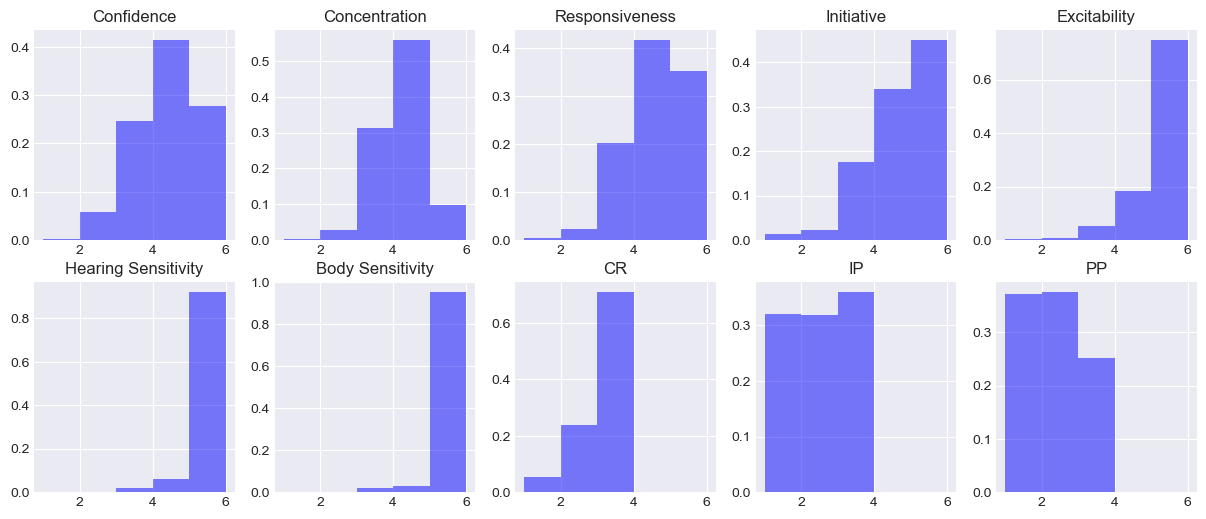

In [15]:
# Histogram Plots of All Dogs
ax_idx = []
for i in np.arange(0,len(Env_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Env_Idx1)/5)),
                             ncols = 5,
                             figsize = (15,6))
histplots(data_env[Env_Idx1], Env_Idx1, ax_idx)
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 1500x600 with 10 Axes>>

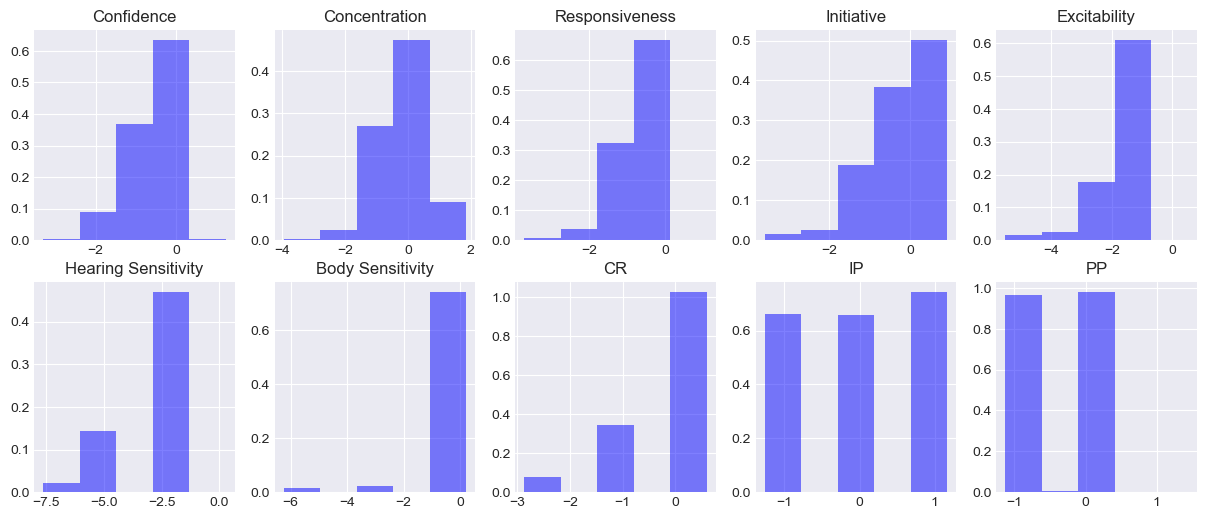

In [16]:
# Histogram Plots of Normalized Env Data
ax_idx = []
for i in np.arange(0,len(Env_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Env_Idx1)/5)),
                             ncols = 5,
                             figsize = (15,6))
normplots(norm_env[Env_Idx1], Env_Idx1, ax_idx)
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 1500x600 with 10 Axes>>

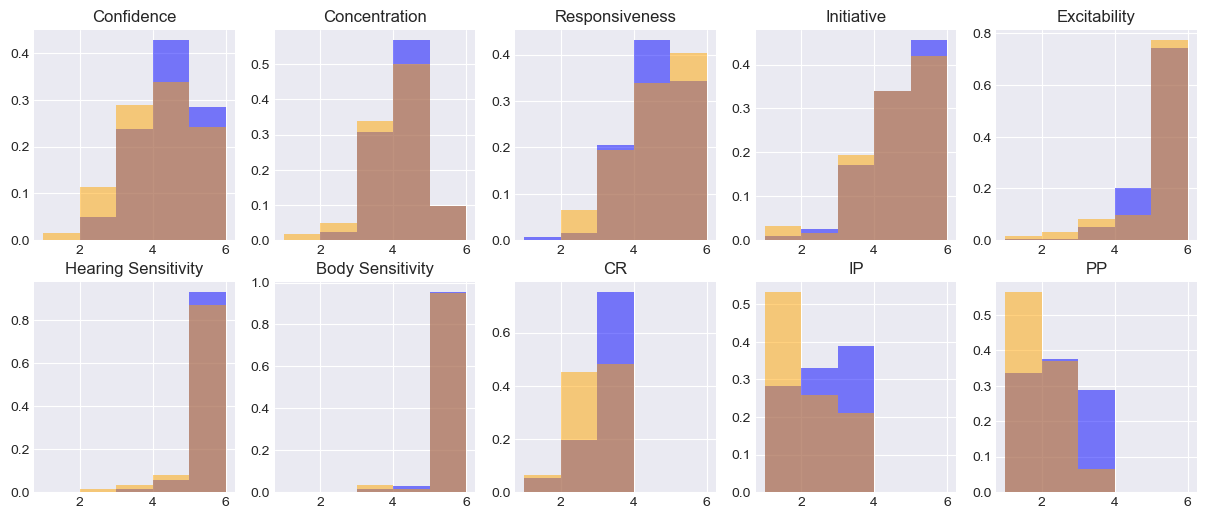

In [17]:
# Histogram Plots of All Dogs Colorized by BehElim Status
ax_idx = []
for i in np.arange(0,len(Env_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Env_Idx1)/5)),
                             ncols = 5,
                             figsize = (15,6))
compareplots(data_env, Env_Idx1, ax_idx)
fig.tight_layout

#### Airport Terminal Tests

In [18]:
data_test   = M03_Test
norm_test   = M03_TestZsc

<bound method Figure.tight_layout of <Figure size 1500x600 with 8 Axes>>

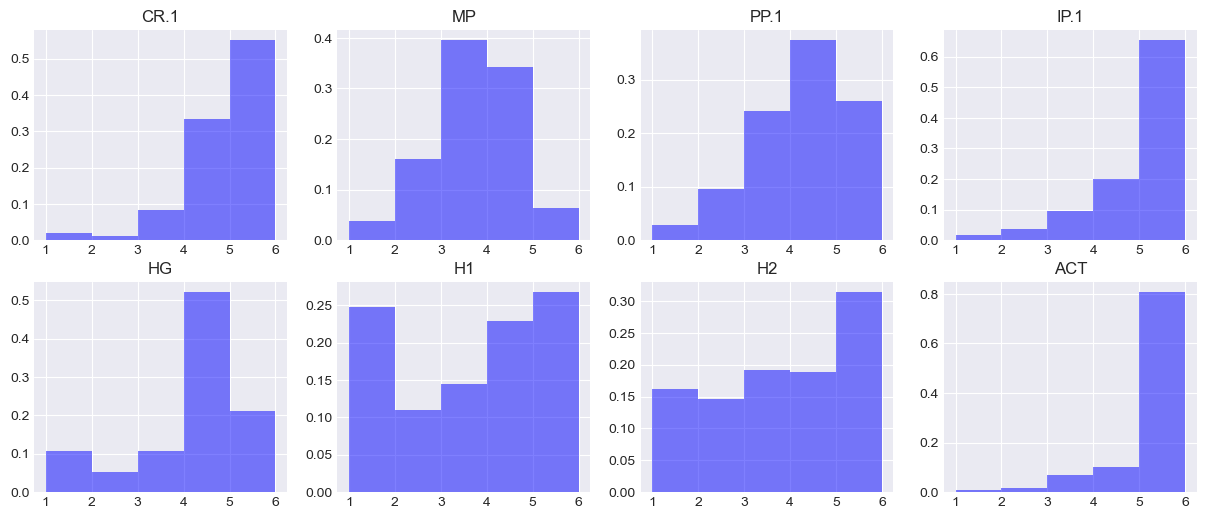

In [19]:
# Histogram Plots of All Dogs
ax_idx = []
for i in np.arange(0,len(Test_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Test_Idx1)/4)),
                             ncols = 4,
                             figsize = (15,6))
histplots(data_test[Test_Idx1], Test_Idx1, ax_idx)
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 1500x600 with 8 Axes>>

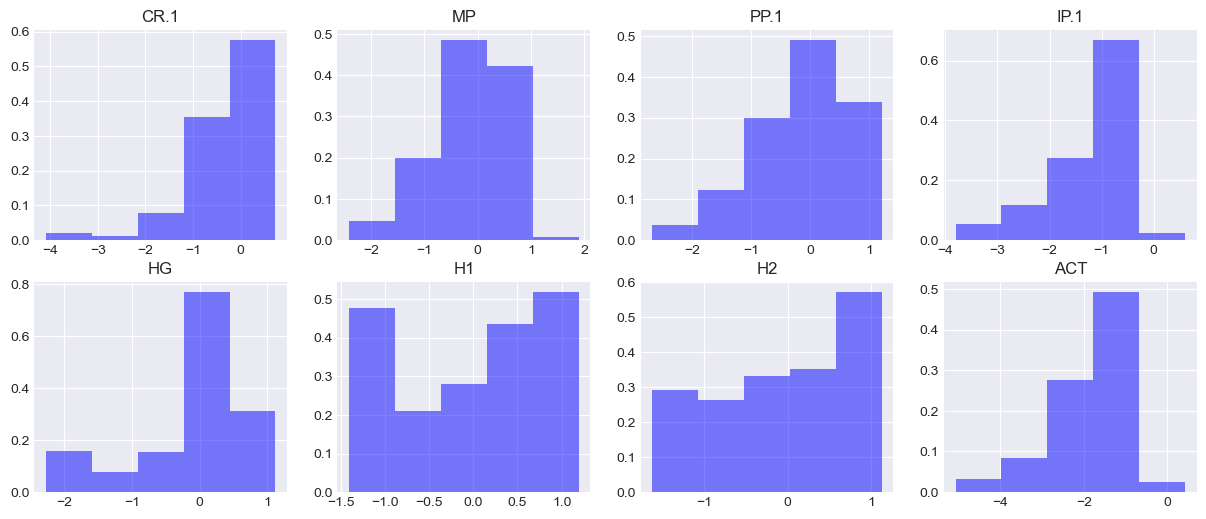

In [20]:
# Histogram Plots of Normalized Airport Terminal Data
ax_idx = []
for i in np.arange(0,len(Env_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Test_Idx1)/4)),
                             ncols = 4,
                             figsize = (15,6))
normplots(norm_test[Test_Idx1], Test_Idx1, ax_idx)
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 1500x600 with 8 Axes>>

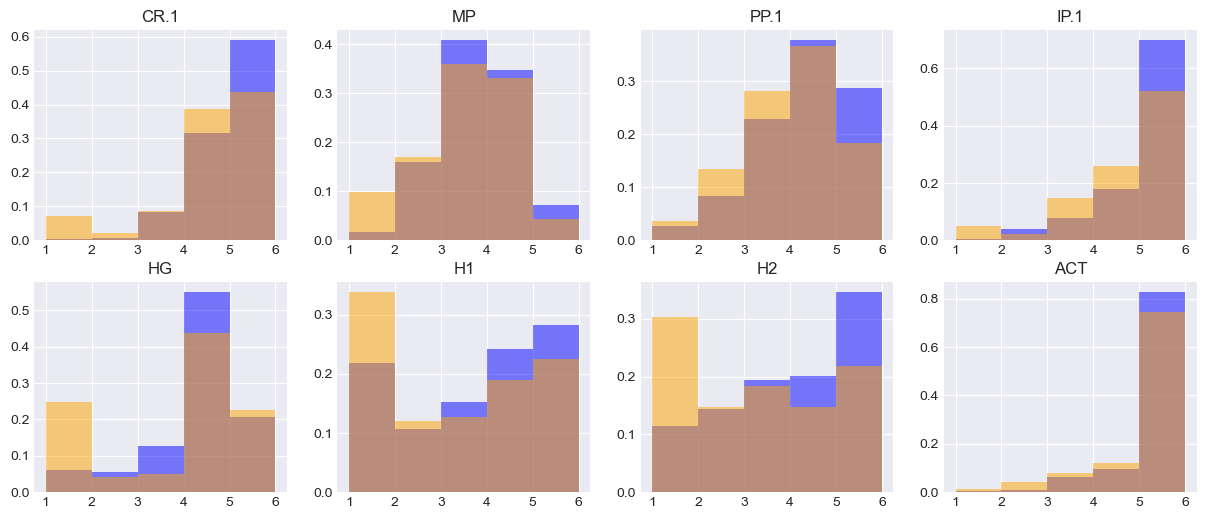

In [21]:
# Histogram Plots of All Dogs Colorized by BehElim Status
ax_idx = []
for i in np.arange(0,len(Test_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Test_Idx1)/4)),
                             ncols = 4,
                             figsize = (15,6))
compareplots(data_test, Test_Idx1, ax_idx)
fig.tight_layout

#### Radar Plots

In [22]:
test_input = "Env"              # Test or Env
elim_status1 = 1                # 0 for accepted, 1 for eliminated
elim_status2 = "Eliminated"     # Accepted or Eliminated

# Do not need to edit
categories = globals()["%s_Idx1" % test_input]
indices = ["M03", "M06", "M09", "M12"]

In [23]:
# Build Data Table
df = pd.DataFrame(np.zeros((len(indices),len(categories))), index = indices, columns = categories)
dtables = ["M03_%s" % test_input, "M06_%s" % test_input, "M09_%s" % test_input, "M12_%s" % test_input]


for category in categories:
    i = 0
    for indx in indices:
        df[category][indx] = np.mean(globals()[dtables[i]][globals()[
                                 dtables[i]]["BehElim"] == elim_status1][category].dropna())
        i = i + 1

In [61]:
# Rename categories for airport terminal test for cleaned up figure
# DO NOT RUN IF VISUALIZING THE ENVIRONMENTAL TESTS

categories = ["CR", "MP", "PP", "IP", "HG", "H1", "H2", "ACT"]

In [24]:
# Radar Plot Values
N          = len(categories)

angles     = [n / float(N) * 2 * pi for n in range(N)]
angles    += angles[:1]

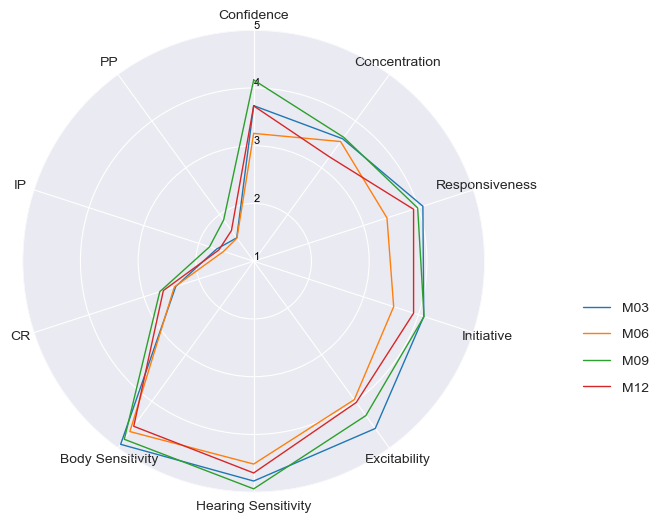

In [25]:
# Initialize Radar Plot
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Set First Point on Top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Set N axes + labels
plt.xticks(angles[:-1], categories)

# Draw y labels
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="black", size=8)
plt.ylim(1,5)

# Fill out Radar Plot
i = 0
while i < len(df):
    values = df.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=indices[i])
    ax.fill(angles, values, 'b', alpha=0.0)
    i = i + 1  
    
ax.legend(
    loc=(1.2,0.2),
    labelspacing=1.0,
    frameon=False
)   
plt.show()

### Machine Learning

#### Choose Dataset

In [26]:
# Set dataset to use - See Data Import & Cleanup
curr_data   = M03_Env
curr_idx    = Env_Idx1

In [27]:
y           = curr_data["BehElim"]
X           = curr_data[curr_idx]
beh_labels  = makelabels(list(y))

### Classification

#### Principal Component Analysis

In [28]:
# Run PCA
pca = PCA(n_components = len(X.columns))
pca.fit(X)
X_pca = pca.transform(X)
components = pca.fit_transform(X[list(X.columns)])

In [29]:
list(pca.explained_variance_ratio_)

[0.443230497633743,
 0.1835855542638746,
 0.08174333488419007,
 0.06169691629111911,
 0.059032713409449426,
 0.05240205219232726,
 0.044716225221398065,
 0.03686815580896384,
 0.023883899104006255,
 0.012840651190928238]

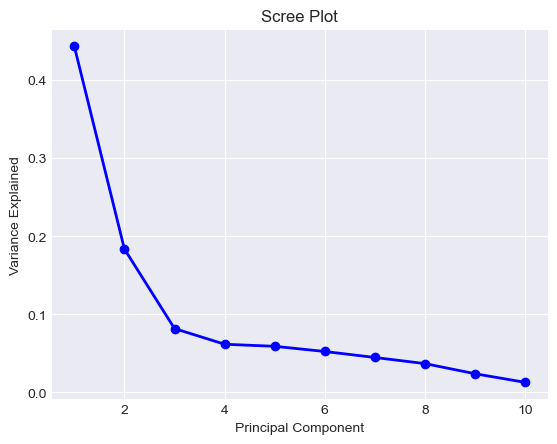

In [30]:
# Scree Plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [31]:
# Find the top two components for plotting PC1 vs. PC2
i   = 0
PC1 = []
PC2 = []
while i < len(X_pca):
    PC1.append(X_pca[i][0])
    PC2.append(X_pca[i][1])
    i = i + 1

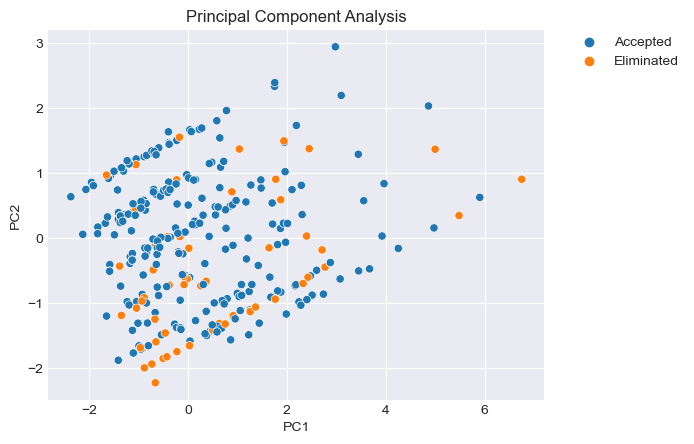

In [32]:
# Plot the top two components against eachother
sns.scatterplot(x = PC1, 
                y = PC2, 
                hue = beh_labels)
plt.title("Principal Component Analysis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

[Text(77.58333333333333, 0.5, 'Components')]

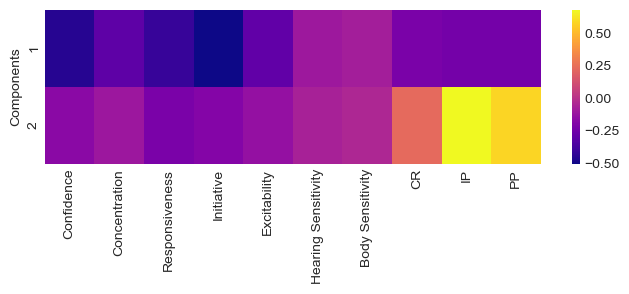

In [34]:
# Heatmap of top 2 principal components using relative strength of traits
df_comp = pd.DataFrame(pca.components_,columns=X.columns)
df_comp.index = np.arange(1,len(components[0])+1)

df_comp = df_comp.iloc[np.arange(0,2)]

plt.figure(figsize=(8,2))
sns.heatmap(df_comp,cmap='plasma').set(ylabel = "Components")

#### Random Forest Feature Selection

In [35]:
# Recursive Feature Elimination with Cross-Validation
rf = RandomForestClassifier(random_state = 1)
rfecv = RFECV(
    estimator = rf,
    step = 1,
    cv = None,
    scoring = "accuracy",
    min_features_to_select = 1
)

In [36]:
# Single RFC run
rfecv.fit(X, list(y))
print("Optimal number of features : %d" % rfecv.n_features_)
print("Features: %s" % " ".join(list(X.columns[rfecv.support_])))

Optimal number of features : 1
Features: Confidence


In [32]:
# Bootstrapped RFC runs
start_time = time.time()
bootstrap_data = bootstrap_FS(X, y, 250)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1808.734709262848 seconds ---


In [37]:
# Save the data to a file
#textfile = open("FS_BS_M12Env.txt", "w")
#for line in bootstrap_data:
#    textfile.write(line)

### Prediction

#### Split Data into Train/Test
Current Splitting 70/30%

In [38]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y,
                                                        test_size = 0.30,
                                                        random_state = 101)

#### Logistic Regression

In [39]:
log_model1 = LogisticRegression()
log_model1.fit(X1_train,y1_train)
log_pred1 = log_model1.predict(X1_test)

In [40]:
print(classification_report(y1_test,log_pred1))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91        98
           1       0.33      0.05      0.09        19

    accuracy                           0.83       117
   macro avg       0.59      0.52      0.50       117
weighted avg       0.76      0.83      0.77       117



In [41]:
logit_roc_auc = roc_auc_score(y1_test, log_model1.predict(X1_test))
print("AUC: %s" % logit_roc_auc)

AUC: 0.5161117078410311


In [42]:
log_model1.classes_

array([0, 1], dtype=int64)

#### Support Vector Machines

In [43]:
svc_model1 = SVC()
svc_model1.fit(X1_train,y1_train)
svc_pred1 = svc_model1.predict(X1_test)

In [44]:
print(confusion_matrix(y1_test,svc_pred1))

[[98  0]
 [19  0]]


In [45]:
print(classification_report(y1_test,svc_pred1))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        98
           1       0.00      0.00      0.00        19

    accuracy                           0.84       117
   macro avg       0.42      0.50      0.46       117
weighted avg       0.70      0.84      0.76       117



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
svc_roc_auc = roc_auc_score(y1_test, svc_model1.predict(X1_test))
print("AUC: %s" % svc_roc_auc)

AUC: 0.5


In [47]:
param_grid = {'C': [0.01,0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid1 = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid1.fit(X1_train,y1_train)
grid_pred1 = grid1.predict(X1_test)
grid1.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [48]:
print(confusion_matrix(y1_test,grid_pred1))

[[97  1]
 [18  1]]


In [49]:
print(classification_report(y1_test,grid_pred1))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91        98
           1       0.50      0.05      0.10        19

    accuracy                           0.84       117
   macro avg       0.67      0.52      0.50       117
weighted avg       0.79      0.84      0.78       117



In [50]:
svc_roc_auc = roc_auc_score(y1_test, grid1.predict(X1_test))
print("AUC: %s" % svc_roc_auc)

AUC: 0.5212137486573576


####  Random Forest

In [51]:
rfc_model1 = RandomForestClassifier(n_estimators=100)
rfc_model1.fit(X1_train, y1_train)
rfc_pred1 = rfc_model1.predict(X1_test)

In [52]:
print(confusion_matrix(y1_test,rfc_pred1))

[[94  4]
 [18  1]]


In [53]:
print(classification_report(y1_test,rfc_pred1))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90        98
           1       0.20      0.05      0.08        19

    accuracy                           0.81       117
   macro avg       0.52      0.51      0.49       117
weighted avg       0.74      0.81      0.76       117



In [54]:
rfc_roc_auc = roc_auc_score(y1_test, rfc_model1.predict(X1_test))
print("AUC: %s" % rfc_roc_auc)

AUC: 0.505907626208378
